In [1]:
from glob import glob
from tqdm import tqdm

import os 

import matplotlib.pyplot as plt

import numpy as np

# cross-validaion 
from sklearn.metrics import classification_report


import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image

from torchvision import transforms as t
from torchvision.transforms import functional as F

import PIL

torch.backends.cudnn.benchmark = True

In [2]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    '''! показывает случайные N выборок из набора данных '''
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize) #количество подграфиков равно длине массива idxs
                                                                                #

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # если кортежем  тогда (x, y)
            sample, label = sample
            if isinstance(label, torch.TensorType):
                label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        axs[0, i].imshow(F.to_pil_image(sample))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

def random_split_ratio(dataset, test_size=.2, random_state=None):
    ''' ! разделение датасета '''
    # получаем длину набора данных
    L = len(dataset)
    
    # вычисляем количество образцов для второй части набора данных (тестовая выборка)
    n_second = int(L * test_size)
    
    # вычисляем количество образцов для первой части набора данных (обучающая выборка)
    n_first = L - n_second
    
    # если указано значение random_state, создаем генератор случайных чисел с заданным seed
    if random_state:
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second], generator=torch.Generator().manual_seed(random_state))
    else:
        # иначе, используем случайный генератор по умолчанию
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second])

    # возвращаем разделенные части набора данных
    return first_split, second_split

def evaluate(dataset, model, device='cpu', **dataloader_args):
    '''! оценка производительности'''
    
    # создаем DataLoader для набора данных с переданными аргументами
    dataloader = DataLoader(dataset, **dataloader_args)
    
    # пустые списки для хранения предсказаний и меток
    preds = []
    labels = []
    
    # отключаем вычисление градиентов и переводим модель в режим оценки
    with torch.no_grad():
        model.eval()
        model.to(device)
        
        # итерируемся по батчам данных в DataLoader
        for x_batch, y_batch in tqdm(dataloader):
            # переносим данные на устройство (GPU или CPU)
            x_batch = x_batch.to(device)
            y_batch = y_batch.tolist()
            
            # получаем выходы модели, применяем softmax и делаем предсказания
            outs = model(x_batch).detach().cpu()
            predictions = torch.argmax(torch.softmax(outs, 1), 1).tolist()
            
            # расширяем списки `preds` и `labels` с предсказаниями и метками
            preds.extend(predictions)
            labels.extend(y_batch)
            
    # генерируем отчет о классификации с использованием предсказаний и меток
    report = classification_report(labels, preds, digits=3)
    report_dict = classification_report(labels, preds, output_dict=True)
    
    # выводим отчет на экран и возвращаем словарь с метриками
    print(report)
    return report_dict


def train(model, loss_fn, train_loader, val_loader, return_model=False, device='cpu', lr_adjuster=None, epochs=10):
    # получаем количество образцов в тренировочном и валидационном наборах данных
    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    
    # пустые списки для хранения потерь на обучении и валидации для каждой эпохи
    training_losses = []
    validation_losses = [] 
    
    # инициализируем оптимизатор и передаем модель на указанное устройство
    optimizer = get_optimizer(model)
    model.to(device)

    print("Number of samples")
    print("Training:", n_train)
    print('Validation:', n_val)
    
    # цикл по эпохам
    for epoch in range(epochs):
        # инициализируем переменные для накопления потерь внутри эпохи
        epoch_training_running_loss = 0
        epoch_val_running_loss = 0
        
        # если используется lr_adjuster, получаем текущий learning rate
        if lr_adjuster:
            lr = lr_adjuster(optimizer, epoch)
        
        # используем tqdm для более наглядного отслеживания прогресса обучения
        bar = tqdm(enumerate(train_loader), total=n_train // train_loader.batch_size)
        
        # цикл по батчам в тренировочном наборе данных
        for batch_idx, (x_batch, y_batch) in bar:
            # переносим данные 
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # вычисляем выходы модели и потерю
            outs = model(x_batch)
            loss = loss_fn(outs, y_batch)
            
            # рассчитываем градиенты и делаем шаг оптимизации
            loss.backward() 
            optimizer.step()
            optimizer.zero_grad()
            
            # накапливаем потери для текущей эпохи
            epoch_training_running_loss += (loss.item() * x_batch.size(0))
        
        # оценка производительности модели на валидационном наборе данных
        with torch.no_grad():
            model.eval()
            vbar = tqdm(val_loader, total=n_val // val_loader.batch_size)
            for x_batch, y_batch in vbar:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                outs = model(x_batch)
                loss = loss_fn(outs, y_batch)
                    
                epoch_val_running_loss += (loss.item() * x_batch.size(0))
            model.train()

        # вычисляем средние потери для текущей эпохи
        average_training_loss = epoch_training_running_loss / n_train
        average_validation_loss = epoch_val_running_loss / n_val
        
        # сохраняем средние потери для текущей эпохи
        training_losses.append(average_training_loss)
        validation_losses.append(average_validation_loss)
        
        # выводим информацию о текущем статусе обучения
        if lr_adjuster:
            print(f"epoch {epoch+1}/{epochs}, lr={lr} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}")
        else:
            print(f"epoch {epoch+1}/{epochs} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}")

    # возвращаем списки потерь на обучении и валидации, а также модель (если return_model=True)
    if return_model:
        return training_losses, validation_losses, model
    else:
        return training_losses, validation_losses


In [3]:
def verify_image(fp):
    try:
        PIL.Image.open(fp).verify()
        return True
    except:
        return False

In [4]:
DATASET_PATH = '../input/microsoft-catsvsdogs-dataset/PetImages' 

In [5]:
class SubsetTransforms(Dataset):
    def __init__(self, subset, transforms):
        """
        инициализация класса SubsetTransforms.

        Args:
            subset (Dataset): поднабор данных, на котором будут применены преобразования.
            transforms (callable): функция (или последовательность функций) для преобразования образцов.
        """
        self.subset = subset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        """
        получение преобразованного образца по индексу.

        Args:
            idx (int): индекс образца в поднаборе данных.

        Returns:
            tuple: преобразованный образец и метка.
        """
        x, y = self.subset[idx]
        return self.transforms(x), y

    def __len__(self):
        """
        получение длины поднабора данных.

        Returns:
            int: длина поднабора данных.
        """
        return len(self.subset)
set)

In [6]:
# обработки изображений перед использованием модели  
transform = t.Compose([
    t.Resize((200, 200)), #размер
    t.ToTensor(), #преобразуется в тензор. Диапазон значений пикселей будет от 0 до 1.
    t.ConvertImageDtype(torch.float32)
])

training_transform = t.Compose([
    t.Resize((200, 200)),
    t.RandomRotation([0,45]), # вращение изображения в пределах угла от 0 до 45 градусов. for лучшего обучения(устойчивости)
    t.ToTensor(),
    t.ConvertImageDtype(torch.float32)
])

dataset = torchvision.datasets.ImageFolder(DATASET_PATH, is_valid_file=verify_image)


#разделение на тест и валид
training_dataset, test_dataset = random_split_ratio(dataset, random_state=42)
training_dataset, validation_dataset = random_split_ratio(training_dataset, random_state=42)

training_dataset = SubsetTransforms(training_dataset, training_transform)
test_dataset = SubsetTransforms(test_dataset, transform)
validation_dataset = SubsetTransforms(validation_dataset, transform)

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [7]:
#создадим метки
labels_to_idx = {"Dog":1, "Cat":0}
idx_to_labels = {0: "Cat", 1: "Dog"}

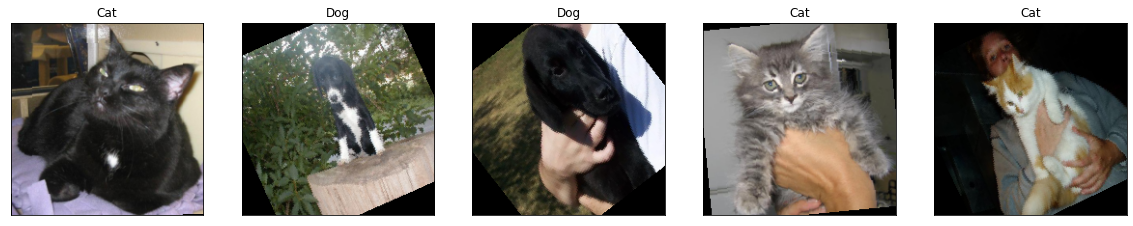

In [8]:
show(training_dataset, labels=idx_to_labels)

In [9]:


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # инициализация модели ResNet-18 с предобученными весами
        self.model = torchvision.models.resnet18(pretrained=True)
        
        # замена последнего полносвязного слоя на новый слой с 2 выходами
        self.model.fc = nn.Linear(512, 2)

        # список слоев, которые будут разморожены (требующие градиентов)
        unfreeze = ['layer4', 'fc']
        
        # проход по всем параметрам модели и установка требования градиентов
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True  # Размораживаем слой
                    break
                else:
                    layer.requires_grad = False  # Замораживаем слой, если не в списке разморозки
    
    def forward(self, x):
        return self.model(x)


In [10]:

def get_optimizer(net):
    # создание оптимизатора Adam
    # фильтрация параметров модели, чтобы в оптимизатор попали только те, для которых requires_grad = True
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=2e-4, betas=(0.9, 0.999), eps=1e-8)
    return optimizer

def get_model():
    # функция возвращает экземпляр модели Model
    return Model()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Number of samples
Training: 16000
Validation: 3999


63it [01:48,  1.73s/it]                        
16it [00:24,  1.53s/it]                        


epoch 1/10, lr=3e-05 | avg. training loss: 0.220, avg. validation loss: 0.081


63it [01:40,  1.60s/it]                        
16it [00:23,  1.50s/it]                        


epoch 2/10, lr=0.0001 | avg. training loss: 0.078, avg. validation loss: 0.056


63it [01:42,  1.63s/it]                        
16it [00:23,  1.49s/it]                        


epoch 3/10, lr=0.0001 | avg. training loss: 0.046, avg. validation loss: 0.054


63it [01:44,  1.66s/it]                        
16it [00:24,  1.52s/it]                        


epoch 4/10, lr=0.0001 | avg. training loss: 0.035, avg. validation loss: 0.054


63it [01:41,  1.60s/it]                        
16it [00:24,  1.51s/it]                        


epoch 5/10, lr=0.0001 | avg. training loss: 0.021, avg. validation loss: 0.059


63it [01:42,  1.62s/it]                        
16it [00:26,  1.68s/it]                        


epoch 6/10, lr=1e-05 | avg. training loss: 0.016, avg. validation loss: 0.053


63it [01:43,  1.64s/it]                        
16it [00:24,  1.51s/it]                        


epoch 7/10, lr=1e-05 | avg. training loss: 0.014, avg. validation loss: 0.052


63it [01:40,  1.60s/it]                        
16it [00:24,  1.56s/it]                        


epoch 8/10, lr=1e-05 | avg. training loss: 0.011, avg. validation loss: 0.054


63it [01:41,  1.61s/it]                        
16it [00:23,  1.49s/it]                        


epoch 9/10, lr=6e-06 | avg. training loss: 0.010, avg. validation loss: 0.054


63it [01:40,  1.59s/it]                        
16it [00:24,  1.53s/it]                        

epoch 10/10, lr=6e-06 | avg. training loss: 0.011, avg. validation loss: 0.053


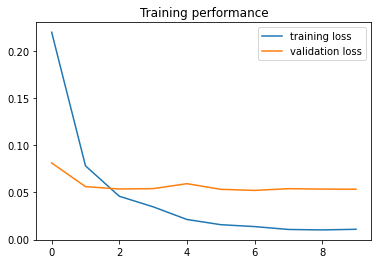

In [11]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 3e-5
    
    elif epoch < 5:
        lr = 1e-4
    
    elif epoch < 8:
        lr = 1e-5
    else:
        lr = 6e-6
        
    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
        
train_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

model = Model()
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_loss, validation_loss, model = train(model, loss_fn, train_loader, val_loader, 
                                              lr_adjuster=adjust_lr, return_model=True, device=device, epochs=10)

plt.title('Training performance') #тренировочная производительность
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()
plt.show()

In [12]:
import gc
gc.collect() #сборщик мусора для освобождения неиспользуемой памяти

37032

In [13]:
print("total allocated memory on gpu (pytorch):", torch.cuda.memory.memory_allocated(device)) #общая выделенная память

total allocated memory on gpu (pytorch): 78344192


In [14]:
print("Training report")
training_report = evaluate(training_dataset, model, device=device, batch_size=256)
print("Validation report")
validation_report = evaluate(validation_dataset, model, device=device, batch_size=256)

Training report


100%|██████████| 63/63 [01:38<00:00,  1.57s/it]


              precision    recall  f1-score   support

           0      0.999     0.998     0.998      8011
           1      0.998     0.998     0.998      7989

    accuracy                          0.998     16000
   macro avg      0.998     0.998     0.998     16000
weighted avg      0.998     0.998     0.998     16000

Validation report


100%|██████████| 16/16 [00:23<00:00,  1.47s/it]

              precision    recall  f1-score   support

           0      0.979     0.983     0.981      1985
           1      0.984     0.980     0.982      2014

    accuracy                          0.981      3999
   macro avg      0.981     0.982     0.981      3999
weighted avg      0.982     0.981     0.981      3999



In [15]:
print("Test report")
test_report = evaluate(test_dataset, model, device=device, batch_size=256)

Test report


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]

              precision    recall  f1-score   support

           0      0.982     0.980     0.981      2503
           1      0.980     0.982     0.981      2496

    accuracy                          0.981      4999
   macro avg      0.981     0.981     0.981      4999
weighted avg      0.981     0.981     0.981      4999



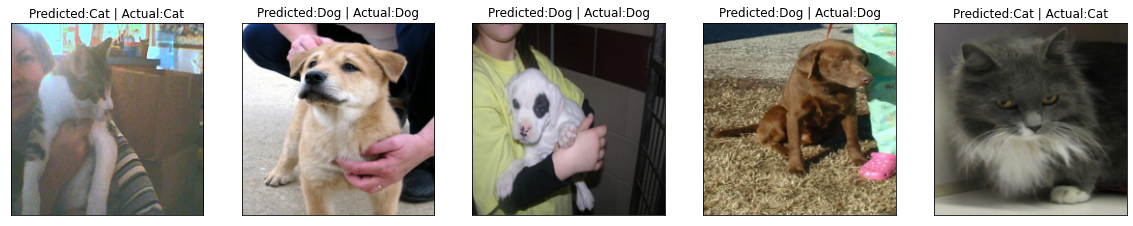

In [16]:
N=5
random_indices = np.random.randint(0, len(test_dataset)-1, N)
random_samples = [test_dataset[i] for i in random_indices]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,20))

for i in range(N):
    sample = random_samples[i]
    image, label = sample
    category = idx_to_labels[label]
    
    input_image = image.unsqueeze(0).to(device)
    model_output = model(input_image)
    prediction = torch.argmax(torch.softmax(model_output, -1)).item()
    predicted_category = idx_to_labels[prediction]
    
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    axs[i].set_title(f'Predicted:{predicted_category} | Actual:{category}')
plt.show()

graph(%input : Float(*, 3, 200, 200, strides=[120000, 40000, 200, 1], requires_grad=0, device=cuda:0),
      %model.fc.weight : Float(2, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %model.fc.bias : Float(2, strides=[1], requires_grad=1, device=cuda:0),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cuda:0),
      %194 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %197 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %200 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %203 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
   